
# Notes


## Overview

- Two stage Sampling Used for CondiSeg but not (Seg Both Mode). I would like to do another experiment with two stage sampling turned on for SegBoth.
- Reversed CondiSeg Results should be finished this morning. Will need to incorporate.
- Concern about the poor segmentation on the CT Image. Why is this? Empirical knowledge shows DICE should be above 90% for other anatomical segmentation. Would expect 70 - 80 DICE for bladder. 

## Todo:


- Run each model at their best epoch under 20K on the Test set.
- Confidence Intervals on the Test Metric (aggregating over folds).
- Confidence Intervals for Validation Metric (aggregating over folds).
- Rerun Segmentation of CBCT and CT (Seg Both Mode) with two-stage sampling.
- Plot Standard Deviation with the Mean DICE for validation and test on same plot.
- Look at predictions see if there are any obvious problems with all images.
    -- Is the wrong anatomical structure being segmented? 






# Preprocessing

## Installs

In [1]:
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn

## Imports

In [2]:
import os
import sys
import pathlib
print(pathlib.Path().resolve())
from glob import glob

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns



/home/bot/thesis/conditional_segmentation_thesis


## Create DataFrame

In [3]:
#Get files containing logs
pattern = './Experiments/**/running_logs/*' #Gets all the log files
files = glob(pattern, recursive=True)
[print(i) for i in files if not None]


./Experiments/exp_3_segBoth_2_sample/CBCTUnetSeg/running_logs/segModeBoth_2sample_CV6_train_log_6.txt
./Experiments/exp_3_segBoth_2_sample/CBCTUnetSeg/running_logs/segModeBoth_2sample_CV4_train_log_4.txt
./Experiments/exp_3_segBoth_2_sample/CBCTUnetSeg/running_logs/segModeBoth_2sample_CV0_train_log_0.txt
./Experiments/exp_3_segBoth_2_sample/CBCTUnetSeg/running_logs/segModeBoth_2sample_CV3_train_log_3.txt
./Experiments/exp_3_segBoth_2_sample/CBCTUnetSeg/running_logs/segModeBoth_2sample_CV1_train_log_1.txt
./Experiments/exp_3_segBoth_2_sample/CBCTUnetSeg/running_logs/segModeBoth_2sample_CV2_train_log_2.txt
./Experiments/exp_3_segBoth_2_sample/CBCTUnetSeg/running_logs/segModeBoth_2sample_CV7_train_log_7.txt
./Experiments/exp_3_segBoth_2_sample/CBCTUnetSeg/running_logs/segModeBoth_2sample_CV5_train_log_5.txt
./Experiments/exp_2_CS_and_CSRev/ConditionalSeg/running_logs/CondisegCBCT_cv4_nc16_train_log_4.txt
./Experiments/exp_2_CS_and_CSRev/ConditionalSeg/running_logs/CondisegCBCT_cv2_nc16_tr

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [4]:
#Get First File
df = pd.read_csv(files[0])

#Join rest of files without header.
df = pd.concat([df] + [pd.read_csv(i) for i in files[1:]], ignore_index = True, axis = 0)
df.head(500) #Quick check

,project,exp_name,fold,train_val_test,epoch,value,value_type
0,CBCTUnetSeg,segModeBoth_2sample_CV6,6,'train',1.0,2.897165,'loss'
1,CBCTUnetSeg,segModeBoth_2sample_CV6,6,'val',1.0,0.028043,'dice_mean'
2,CBCTUnetSeg,segModeBoth_2sample_CV6,6,'val',1.0,0.017969,'dice_std'
3,CBCTUnetSeg,segModeBoth_2sample_CV6,6,'train',2.0,2.84397,'loss'
4,CBCTUnetSeg,segModeBoth_2sample_CV6,6,'val',2.0,0.109517,'dice_mean'
...,...,...,...,...,...,...,...
495,CBCTUnetSeg,segModeBoth_2sample_CV6,6,'train',166.0,2.524223,'loss'
496,CBCTUnetSeg,segModeBoth_2sample_CV6,6,'val',166.0,0.291911,'dice_mean'
497,CBCTUnetSeg,segModeBoth_2sample_CV6,6,'val',166.0,0.320591,'dice_std'
498,CBCTUnetSeg,segModeBoth_2sample_CV6,6,'train',167.0,2.621474,'loss'


In [5]:
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3621232 entries, 0 to 3621231
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   project         object 
 1   exp_name        object 
 2   fold            object 
 3   train_val_test  object 
 4   epoch           float64
 5   value           object 
 6   value_type      object 
dtypes: float64(1), object(6)
memory usage: 193.4+ MB
None
              epoch
count  3.621232e+06
mean   9.980344e+03
std    5.741036e+03
min    6.131642e-01
25%    5.023000e+03
50%    9.970000e+03
75%    1.491900e+04
max    2.000000e+04
       project                 exp_name fold train_val_test  epoch     value  \
0  CBCTUnetSeg  segModeBoth_2sample_CV6    6        'train'    1.0  2.897165   
1  CBCTUnetSeg  segModeBoth_2sample_CV6    6          'val'    1.0  0.028043   
2  CBCTUnetSeg  segModeBoth_2sample_CV6    6          'val'    1.0  0.017969   
3  CBCTUnetSeg  segModeBoth_2sample_CV6    6        'train'    2.0  

In [6]:
list(df.exp_name.unique())

['segModeBoth_2sample_CV6',
 'segModeBoth_2sample_CV4',
 'segModeBoth_2sample_CV0',
 'segModeBoth_2sample_CV3',
 'segModeBoth_2sample_CV1',
 'segModeBoth_2sample_CV2',
 'segModeBoth_2sample_CV7',
 'segModeBoth_2sample_CV5',
 'CondisegCBCT_cv4_nc16',
 'CondisegCBCT_cv2_nc16',
 '0',
 'CondisegCBCT_cv0_nc16',
 'CondisegCBCT_cv7_nc16',
 'CondisegCBCT_cv1_nc16',
 'CondisegCBCT_cv6_nc16',
 'CondisegCBCT_cv3_nc16',
 'CondisegReversed_cv0_nc16',
 'CondisegReversed_cv2_nc16',
 'CondisegReversed_cv6_nc16',
 'CondisegReversed_cv7_nc16',
 'CondisegReversed_cv3_nc16',
 'CondisegReversed_cv5_nc16',
 'CondisegReversed_cv1_nc16',
 'CBCT_Infer_CondisegReversed_cv1_nc16',
 'CBCT_Infer_CondisegReversed_cv5_nc16',
 'CBCT_Infer_CondisegReversed_cv7_nc16',
 'CBCT_Infer_CondisegReversed_cv2_nc16',
 'CBCT_Infer_CondisegReversed_cv3_nc16',
 'CBCT_Infer_CondisegReversed_cv0_nc16',
 'CBCT_Infer_CondisegReversed_cv6_nc16',
 'inoutsegModeCTCV4',
 'inoutsegModeCTCV7',
 'inoutsegModeCTCV6',
 'inoutsegModeCTCV2',
 'i

In [7]:
df.drop(df[df['exp_name'] =='0'].index, inplace=True)

In [8]:
#One was a NaN which was obviously a condisegreversed by exp_name. Update to the correct project
df[df['project'].isna()] = 'ConditionalSegReversed'

In [9]:
df.drop(df[df['exp_name'] == 'ConditionalSegReversed'].index, inplace=True)

In [10]:
df[df['project'] == 'ConditionalSegReversed']


,project,exp_name,fold,train_val_test,epoch,value,value_type
891834,ConditionalSegReversed,CondisegReversed_cv0_nc16,0,'val',1880.0,0.694682,'dice_mean'
891835,ConditionalSegReversed,CondisegReversed_cv0_nc16,0,'val',1880.0,0.165893,'dice_std'
891836,ConditionalSegReversed,CondisegReversed_cv0_nc16,0,'train',1881.0,0.09328,'loss'
891837,ConditionalSegReversed,CondisegReversed_cv0_nc16,0,'val',1881.0,0.684008,'dice_mean'
891838,ConditionalSegReversed,CondisegReversed_cv0_nc16,0,'val',1881.0,0.157302,'dice_std'
...,...,...,...,...,...,...,...
1306191,ConditionalSegReversed,CondisegReversed_cv1_nc16,1,'val',19999.0,0.777189,'dice_mean'
1306192,ConditionalSegReversed,CondisegReversed_cv1_nc16,1,'val',19999.0,0.145258,'dice_std'
1306193,ConditionalSegReversed,CondisegReversed_cv1_nc16,1,'train',20000.0,0.043498,'loss'
1306194,ConditionalSegReversed,CondisegReversed_cv1_nc16,1,'val',20000.0,0.773943,'dice_mean'


In [11]:
#Convert Fields to correct type
df['value'] = df['value'].astype(float)
df['fold'] = df['fold'].astype(int)
df['project'] = df['project'].astype(str)
df['exp_name'] = df['exp_name'].astype(str)
df['epoch'] = df['epoch'].astype(int)
df['train_val_test'].str.replace("'", "")
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3621230 entries, 0 to 3621231
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   project         object 
 1   exp_name        object 
 2   fold            int64  
 3   train_val_test  object 
 4   epoch           int64  
 5   value           float64
 6   value_type      object 
dtypes: float64(1), int64(2), object(4)
memory usage: 221.0+ MB


## Experiment Setup

### For Curves

In [12]:
# df[df['exp_name'].startswith'segModeBoth'].head()

In [13]:
# #change segModeBoth_2sample to 2sample_segModeBoth
# df[df['exp_name'].startswith('segModeBoth_2sample')]['exp_name'] = '2sample_segModeBoth'
# #df[df['exp_name'] == 'segModeBoth_2sample'] = '2sample_segModeBoth'
# df[df['exp_name'] == '2sample_segModeBoth'].head()

df

In [14]:
projects = df.project.unique().tolist() #Get unique projects
projects

['CBCTUnetSeg', 'ConditionalSeg', 'ConditionalSegReversed']

In [15]:
experiments = df.exp_name.unique().tolist()
print(df.exp_name.unique().tolist().sort()) #get unique experiments
experiments.sort() #sort alphanumerically

None


In [16]:
print(experiments)

['CBCT_Infer_CondisegReversed_cv0_nc16', 'CBCT_Infer_CondisegReversed_cv1_nc16', 'CBCT_Infer_CondisegReversed_cv2_nc16', 'CBCT_Infer_CondisegReversed_cv3_nc16', 'CBCT_Infer_CondisegReversed_cv5_nc16', 'CBCT_Infer_CondisegReversed_cv6_nc16', 'CBCT_Infer_CondisegReversed_cv7_nc16', 'CondisegCBCT_cv0_nc16', 'CondisegCBCT_cv1_nc16', 'CondisegCBCT_cv2_nc16', 'CondisegCBCT_cv3_nc16', 'CondisegCBCT_cv4_nc16', 'CondisegCBCT_cv6_nc16', 'CondisegCBCT_cv7_nc16', 'CondisegReversed_cv0_nc16', 'CondisegReversed_cv1_nc16', 'CondisegReversed_cv2_nc16', 'CondisegReversed_cv3_nc16', 'CondisegReversed_cv5_nc16', 'CondisegReversed_cv6_nc16', 'CondisegReversed_cv7_nc16', 'inoutsegModeCTCV0', 'inoutsegModeCTCV1', 'inoutsegModeCTCV2', 'inoutsegModeCTCV3', 'inoutsegModeCTCV4', 'inoutsegModeCTCV5', 'inoutsegModeCTCV6', 'inoutsegModeCTCV7', 'segModeBothCV0', 'segModeBothCV1', 'segModeBothCV2', 'segModeBothCV3', 'segModeBothCV4', 'segModeBothCV5', 'segModeBothCV6', 'segModeBothCV7', 'segModeBoth_2sample_CV0', 's

In [17]:
experiments = list(df.exp_name.unique()) #get unique experiments
print(experiments.sort())
experiments
exp_types = ['CondisegCBCT', 'CondisegReversed', 'segModeBoth', 'segModeCBCT', 'segModeCT', 'segModeBoth_2sample']

None


In [18]:
exp_type = exp_types[0]
df[df['exp_name'].str.startswith(exp_type)] 

,project,exp_name,fold,train_val_test,epoch,value,value_type
480000,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'train',1,0.886185,'loss'
480001,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'val',1,0.080423,'dice_mean'
480002,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'val',1,0.070590,'dice_std'
480003,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'train',2,0.894790,'loss'
480004,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'val',2,0.014435,'dice_mean'
...,...,...,...,...,...,...,...
891828,ConditionalSeg,CondisegCBCT_cv3_nc16,3,'val',19999,0.750035,'dice_mean'
891829,ConditionalSeg,CondisegCBCT_cv3_nc16,3,'val',19999,0.187823,'dice_std'
891830,ConditionalSeg,CondisegCBCT_cv3_nc16,3,'train',20000,0.051964,'loss'
891831,ConditionalSeg,CondisegCBCT_cv3_nc16,3,'val',20000,0.749346,'dice_mean'


In [19]:
#Creata a dictionary to map experiment name to a friendly name to be displayed on the chart for the corresponding experiment.
exp_name_title_mapping = {'CondisegCBCT': "Conditional Segmentation Algorithm (INPUT: Condi; OUT: CBCT Seg)",
                          'CondisegReversed': "Conditional Segmentation Algorithm (Reversed) (INPUT: Condi Reversed; OUT: CT Seg)",
                          'segModeBoth': "CBCT & CT Segmentation (No 2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)",
                          'segModeCBCT': "CBCT Segmentation (INPUT: CBCT; OUT: CBCT Seg)",
                          'segModeCT': "CT Segmentation (INPUT: CT; OUT: CBCT Seg)",
                          'segModeBoth_2sample': "CBCT & CT Segmentation (2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)",
                          "inoutsegModeCT": "(INPUT: CT; OUT: CT Seg)",
                          "CBCT_Infer_CondisegReversed": "(INPUT: Condi Reversed; OUT: CBCT Seg)"}


### For Visualization

In [20]:
#Get files containing running logs.
pattern = './Experiments/**/running_logs/*' #Gets all the log files
files = glob(pattern, recursive=True)
[print(i) for i in files if not None]

./Experiments/exp_3_segBoth_2_sample/CBCTUnetSeg/running_logs/segModeBoth_2sample_CV6_train_log_6.txt
./Experiments/exp_3_segBoth_2_sample/CBCTUnetSeg/running_logs/segModeBoth_2sample_CV4_train_log_4.txt
./Experiments/exp_3_segBoth_2_sample/CBCTUnetSeg/running_logs/segModeBoth_2sample_CV0_train_log_0.txt
./Experiments/exp_3_segBoth_2_sample/CBCTUnetSeg/running_logs/segModeBoth_2sample_CV3_train_log_3.txt
./Experiments/exp_3_segBoth_2_sample/CBCTUnetSeg/running_logs/segModeBoth_2sample_CV1_train_log_1.txt
./Experiments/exp_3_segBoth_2_sample/CBCTUnetSeg/running_logs/segModeBoth_2sample_CV2_train_log_2.txt
./Experiments/exp_3_segBoth_2_sample/CBCTUnetSeg/running_logs/segModeBoth_2sample_CV7_train_log_7.txt
./Experiments/exp_3_segBoth_2_sample/CBCTUnetSeg/running_logs/segModeBoth_2sample_CV5_train_log_5.txt
./Experiments/exp_2_CS_and_CSRev/ConditionalSeg/running_logs/CondisegCBCT_cv4_nc16_train_log_4.txt
./Experiments/exp_2_CS_and_CSRev/ConditionalSeg/running_logs/CondisegCBCT_cv2_nc16_tr

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Plot Helpers

In [21]:
df.exp_name.unique()

array(['segModeBoth_2sample_CV6', 'segModeBoth_2sample_CV4',
       'segModeBoth_2sample_CV0', 'segModeBoth_2sample_CV3',
       'segModeBoth_2sample_CV1', 'segModeBoth_2sample_CV2',
       'segModeBoth_2sample_CV7', 'segModeBoth_2sample_CV5',
       'CondisegCBCT_cv4_nc16', 'CondisegCBCT_cv2_nc16',
       'CondisegCBCT_cv0_nc16', 'CondisegCBCT_cv7_nc16',
       'CondisegCBCT_cv1_nc16', 'CondisegCBCT_cv6_nc16',
       'CondisegCBCT_cv3_nc16', 'CondisegReversed_cv0_nc16',
       'CondisegReversed_cv2_nc16', 'CondisegReversed_cv6_nc16',
       'CondisegReversed_cv7_nc16', 'CondisegReversed_cv3_nc16',
       'CondisegReversed_cv5_nc16', 'CondisegReversed_cv1_nc16',
       'CBCT_Infer_CondisegReversed_cv1_nc16',
       'CBCT_Infer_CondisegReversed_cv5_nc16',
       'CBCT_Infer_CondisegReversed_cv7_nc16',
       'CBCT_Infer_CondisegReversed_cv2_nc16',
       'CBCT_Infer_CondisegReversed_cv3_nc16',
       'CBCT_Infer_CondisegReversed_cv0_nc16',
       'CBCT_Infer_CondisegReversed_cv6_nc16', 

In [44]:
exp_types

['CondisegCBCT',
 'CondisegReversed',
 'segModeBoth',
 'segModeCBCT',
 'segModeCT',
 'segModeBoth_2sample']

In [23]:
exp_grouping = {}
#Create a dictionary to map experiment name to a list of experiments that are part of the same group.
#Loop through all unique experiment names (one for each fold per experiment)
for exp_name in df.exp_name.unique().tolist():
    #Then loop through the exp_types which are unique exp_name prefixes. Map to the Grouping
    #print(f"exp_name: {exp_name}")
    for exp_type in exp_name_title_mapping.keys():
        #print(f'exp_type: {exp_type}')
        if exp_name.startswith('segModeBoth_2sample'):
            exp_grouping[exp_name] = exp_name_title_mapping['segModeBoth_2sample']
            break
        elif exp_name.startswith('segModeBoth'):
            exp_grouping[exp_name] = exp_name_title_mapping['segModeBoth']
            break
        if exp_name.startswith(exp_type):
            exp_grouping[exp_name] = exp_name_title_mapping[exp_type]
            break #break out of the loop since we found the exp_type

print(f'exp_grouping: {exp_grouping}')

df['experiment_group'] = df['exp_name'].map(exp_grouping)

exp_grouping: {'segModeBoth_2sample_CV6': 'CBCT & CT Segmentation (2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)', 'segModeBoth_2sample_CV4': 'CBCT & CT Segmentation (2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)', 'segModeBoth_2sample_CV0': 'CBCT & CT Segmentation (2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)', 'segModeBoth_2sample_CV3': 'CBCT & CT Segmentation (2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)', 'segModeBoth_2sample_CV1': 'CBCT & CT Segmentation (2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)', 'segModeBoth_2sample_CV2': 'CBCT & CT Segmentation (2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)', 'segModeBoth_2sample_CV7': 'CBCT & CT Segmentation (2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)', 'segModeBoth_2sample_CV5': 'CBCT & CT Segmentation (2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)', 'CondisegCBCT_cv4_nc16': 'Conditional Segmentation Algorithm (INPUT: Condi; OUT: CBCT Seg)', 'Con

In [24]:
df['experiment_group'].unique().tolist()

['CBCT & CT Segmentation (2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)',
 'Conditional Segmentation Algorithm (INPUT: Condi; OUT: CBCT Seg)',
 'Conditional Segmentation Algorithm (Reversed) (INPUT: Condi Reversed; OUT: CT Seg)',
 nan,
 'CBCT Segmentation (INPUT: CBCT; OUT: CBCT Seg)',
 'CBCT & CT Segmentation (No 2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)',
 'CT Segmentation (INPUT: CT; OUT: CBCT Seg)']

In [25]:
def plot_data_aggregate(exp_types, train_val_test, value_type, max_epochs, every_nth_epoch, title = None, y_label = 'Value'):
    

    # 
    df_local = df[df['epoch'] % every_nth_epoch == 0] #Only get data for every 1000 epochs
    df_local = df_local[df_local['train_val_test'] == train_val_test] #only get training, validation, or test data
    df_local = df_local[df_local['value_type'] == value_type] #only get loss, dice_mean, or dice_std data
    df_local = df_local[df_local['epoch'] <= max_epochs] #Only get data for first 20k epochs
    df_local = df_local.groupby(['experiment_group', 'epoch'], as_index=False).agg({"value": np.mean})
    
    plot = sns.lineplot(x='epoch', y='value', hue='experiment_group', data=df_local, markers=True)

    plot.set(title=title, xlabel='Epoch', ylabel=y_label) #Set title and labels
    # Put the legend out of the figure
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.show()


#TEST
#plot_data_aggregate(exp_types,

In [26]:
def plot_data_by_folds(exp_types, train_val_test, value_type, max_epochs, every_nth_epoch, y_label):
    print(f'exp_types: {exp_types}')
    for exp_type in exp_types:
        ##Only get data for the relevant experiment
        #Check if starts with segModeBoth_2sample
        if exp_type.startswith('segModeBoth_2sample'):
            df_experiment = df[df['exp_name'].str.startswith(exp_type)] #Only get data for this experiment
        #else check for more general exp_type
        elif exp_type.startswith('segModeBoth'):
            df_experiment = df[df['exp_name'].str.startswith(exp_type) & df['exp_name'].str.contains('2sample') == False]
            #Get all items in dataframe where exp_name starts with segModeBoth and does not contain '2sample'
            #df_experiment = df_experiment[df_experiment['exp_name'].str.contains('2sample') == False]
        else:
            df_experiment = df[df['exp_name'].str.startswith(exp_type)]
            
        df_experiment = df_experiment[df_experiment['epoch'] <= max_epochs] #Only get data for first 20k epochs
        df_experiment = df_experiment[df_experiment['epoch'] % every_nth_epoch == 0] #Only get data for every 1000 epochs
        df_experiment = df_experiment[df_experiment['train_val_test'] == train_val_test] #only get training, validation, or test data
        df_experiment = df_experiment[df_experiment['value_type'] == value_type][['epoch', 'value', 'fold']] #only get loss data
        plot = sns.lineplot(x='epoch', y='value', hue='fold', data=df_experiment, ci = None)
        print(f'exp_type: {exp_type}')
        print(f'exp_name_title_mapping[exp_type]: {exp_name_title_mapping[exp_type]}')
        plot.set(title=f"{exp_name_title_mapping[exp_type]}", xlabel='Epoch', ylabel=y_label) #Set title and labels
        plot.legend(title='Fold')
        plt.show()
        plt.clf()

In [27]:
def plot_data_aggregate_by_fold(exp_types, train_val_test, value_type, max_epochs, every_nth_epoch):
    for exp_type in exp_types:
        ##Only get data for the relevant experiment
        #Check if starts with segModeBoth_2sample
        if exp_type.startswith('segModeBoth_2sample'):
            df_experiment = df[df['exp_name'].str.startswith(exp_type)] #Only get data for this experiment
        #else check for more general exp_type
        elif exp_type.startswith('segModeBoth'):
            df_experiment = df[df['exp_name'].str.startswith(exp_type) & df['exp_name'].str.contains('2sample') == False]
            #Get all items in dataframe where exp_name starts with segModeBoth and does not contain '2sample'
            #df_experiment = df_experiment[df_experiment['exp_name'].str.contains('2sample') == False]
        else:
            df_experiment = df[df['exp_name'].str.startswith(exp_type)]
            
        df_experiment = df_experiment[df_experiment['epoch'] <= max_epochs] #Only get data for first 20k epochs
        df_experiment = df_experiment[df_experiment['epoch'] % every_nth_epoch == 0] #Only get data for every 1000 epochs
        df_experiment = df_experiment[df_experiment['train_val_test'] == train_val_test] #only get training, validation, or test data
        df_experiment = df_experiment[df_experiment['value_type'] == value_type][['epoch', 'value', 'fold']] #only get loss data
        x = df_experiment.groupby(['epoch'], as_index=False).agg({"value": np.mean})
        plot = sns.lineplot(x='epoch', y='value', data=x)
        plot.set(title=f"{exp_name_title_mapping[exp_type]} by Epoch", xlabel='Epoch', ylabel='Loss') #Set title and labels
        plt.show()
        plt.clf()

#TEST
#plot_data_aggregate_by_fold(exp_types, "'val'", "'dice_mean'", 20000, 1000)

# Ploting

## Training Loss

todo: Put what was used for the training loss.

### Training Loss Convergence Analysis

#### By Fold

exp_types: ['CondisegCBCT', 'CondisegReversed', 'segModeBoth', 'segModeCBCT', 'segModeCT', 'segModeBoth_2sample']
exp_type: CondisegCBCT
exp_name_title_mapping[exp_type]: Conditional Segmentation Algorithm (INPUT: Condi; OUT: CBCT Seg)


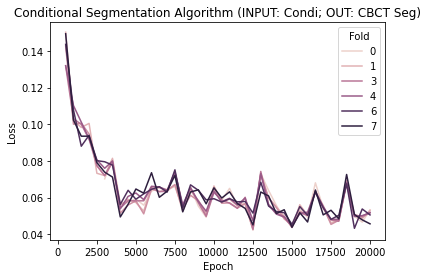

exp_type: CondisegReversed
exp_name_title_mapping[exp_type]: Conditional Segmentation Algorithm (Reversed) (INPUT: Condi Reversed; OUT: CT Seg)


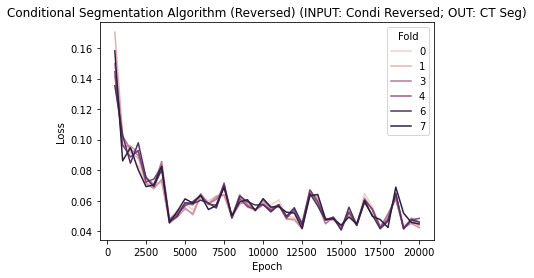

exp_type: segModeBoth
exp_name_title_mapping[exp_type]: CBCT & CT Segmentation (No 2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)


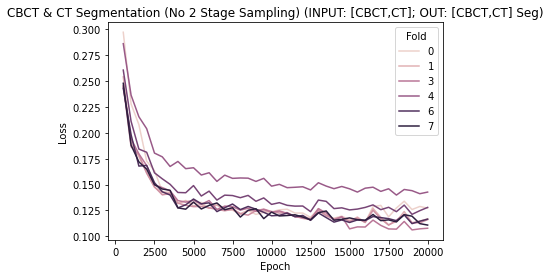

exp_type: segModeCBCT
exp_name_title_mapping[exp_type]: CBCT Segmentation (INPUT: CBCT; OUT: CBCT Seg)


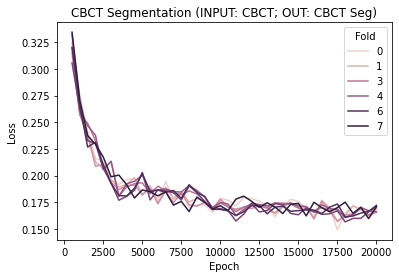

exp_type: segModeCT
exp_name_title_mapping[exp_type]: CT Segmentation (INPUT: CT; OUT: CBCT Seg)


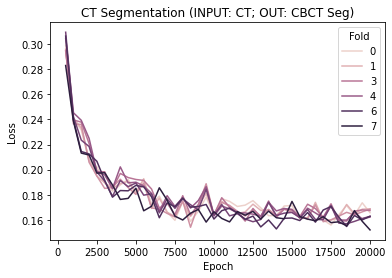

exp_type: segModeBoth_2sample
exp_name_title_mapping[exp_type]: CBCT & CT Segmentation (2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)


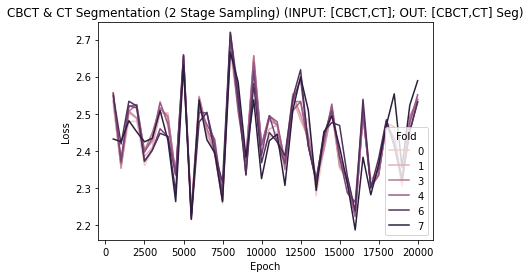

<Figure size 432x288 with 0 Axes>

In [28]:
#Plot an epoch vs Loss graph for the Conditional Segmentation Algorithm 
#Shaded areas are 95% Confidence Intervals of the Mean with 1000 bootstrap samples.
train_val_test = "'train'"
value_type = "'loss'"

plot_data_by_folds(exp_types, train_val_test, value_type, 20000, 500, 'Loss')


In [29]:
exp_name_title_mapping.keys()

dict_keys(['CondisegCBCT', 'CondisegReversed', 'segModeBoth', 'segModeCBCT', 'segModeCT', 'segModeBoth_2sample'])

Experiment 1:
        epoch     value  fold
122997   1000  2.359153     0
125997   2000  2.480214     0
128997   3000  2.402236     0
131997   4000  2.465646     0
134997   5000  2.654518     0
137997   6000  2.514791     0
140997   7000  2.396870     0
143997   8000  2.663935     0
146997   9000  2.383585     0
149997  10000  2.398043     0
152997  11000  2.451382     0
155997  12000  2.538825     0
158997  13000  2.482162     0
161997  14000  2.404492     0
164997  15000  2.352533     0
167997  16000  2.228040     0
170997  17000  2.318331     0
173997  18000  2.474531     0
176997  19000  2.330392     0
179997  20000  2.542703     0
exp_type: segModeCT
exp_name_title_mapping[exp_type]: CT Segmentation (INPUT: CT; OUT: CBCT Seg)


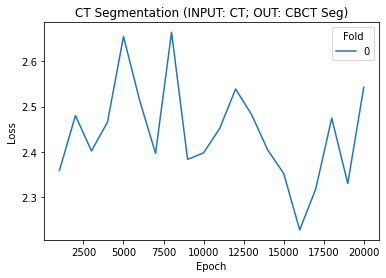

Experiment 2:
         epoch     value  fold
3504229   1000  0.286464     0
3507229   2000  0.239352     0
3510229   3000  0.213915     0
3513229   4000  0.202091     0
3516229   5000  0.199700     0
3519229   6000  0.181898     0
3522229   7000  0.184318     0
3525229   8000  0.176569     0
3528229   9000  0.175428     0
3531229  10000  0.178152     0
3534229  11000  0.176184     0
3537229  12000  0.180802     0
3540229  13000  0.174182     0
3543229  14000  0.171086     0
3546229  15000  0.162483     0
3549229  16000  0.170424     0
3552229  17000  0.178709     0
3555229  18000  0.173851     0
3558229  19000  0.165140     0
3561229  20000  0.168582     0
exp_type: segModeCT
exp_name_title_mapping[exp_type]: CT Segmentation (INPUT: CT; OUT: CBCT Seg)


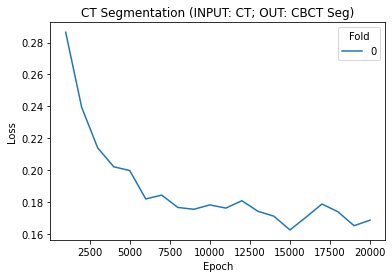

<Figure size 432x288 with 0 Axes>

In [30]:
every_nth_epoch = 1000
epoch = 20000
train_val_test = "'train'"
value_type = "'loss'"

df.exp_name.unique()
df_experiment1 = df[df['exp_name'] == 'segModeBoth_2sample_CV0']
df_experiment1 = df_experiment1[df_experiment1['epoch'] <= epoch] #Only get data for first 20k epochs
df_experiment1 = df_experiment1[df_experiment1['epoch'] % every_nth_epoch == 0] #Only get data for every 1000 epochs
df_experiment1 = df_experiment1[df_experiment1['train_val_test'] == train_val_test] #only get training, validation, or test data
df_experiment1 = df_experiment1[df_experiment1['value_type'] == value_type][['epoch', 'value', 'fold']] #only get loss data


df_experiment2 = df[df['exp_name'] == 'segModeBothCV0']
df_experiment2 = df_experiment2[df_experiment2['epoch'] <= epoch] #Only get data for first 20k epochs
df_experiment2 = df_experiment2[df_experiment2['epoch'] % every_nth_epoch == 0] #Only get data for every 1000 epochs
df_experiment2 = df_experiment2[df_experiment2['train_val_test'] == train_val_test] #only get training, validation, or test data
df_experiment2 = df_experiment2[df_experiment2['value_type'] == value_type][['epoch', 'value', 'fold']] #only get loss data

print("Experiment 1:")
print(df_experiment1)
plot = sns.lineplot(x='epoch', y='value', hue='fold', data=df_experiment1, ci = None)
print(f'exp_type: {exp_type}')
print(f'exp_name_title_mapping[exp_type]: {exp_name_title_mapping[exp_type]}')
plot.set(title=f"{exp_name_title_mapping[exp_type]}", xlabel='Epoch', ylabel='Loss') #Set title and labels
plot.legend(title='Fold')
plt.show()
plt.clf()

print("Experiment 2:")
print(df_experiment2)
plot = sns.lineplot(x='epoch', y='value', hue='fold', data=df_experiment2, ci = None)
print(f'exp_type: {exp_type}')
print(f'exp_name_title_mapping[exp_type]: {exp_name_title_mapping[exp_type]}')
plot.set(title=f"{exp_name_title_mapping[exp_type]}", xlabel='Epoch', ylabel='Loss') #Set title and labels
plot.legend(title='Fold')
plt.show()
plt.clf()


#### By Experiment

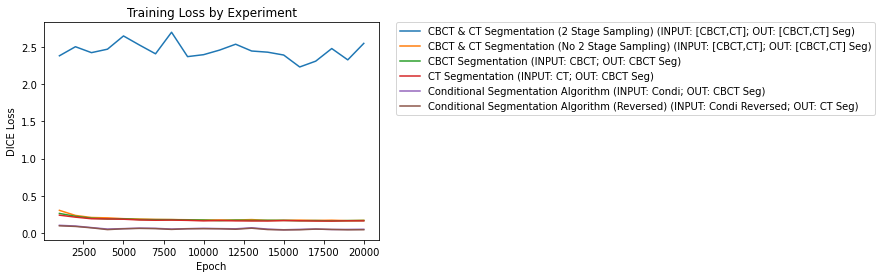

In [31]:
plot_data_aggregate(exp_types, "'train'", "'loss'", 20000, 1000, title='Training Loss by Experiment', y_label = 'DICE Loss')

## Validation Metric

DICE Metric is utilized which is defined as:
todo


### Validation Data Mean DICE Score

#### By Fold

exp_types: ['CondisegCBCT', 'CondisegReversed', 'segModeBoth', 'segModeCBCT', 'segModeCT', 'segModeBoth_2sample']
exp_type: CondisegCBCT
exp_name_title_mapping[exp_type]: Conditional Segmentation Algorithm (INPUT: Condi; OUT: CBCT Seg)


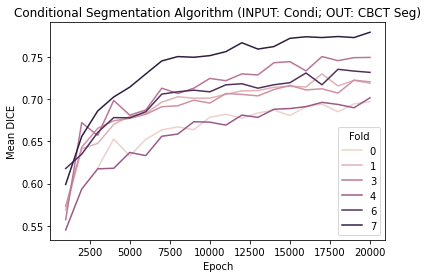

exp_type: CondisegReversed
exp_name_title_mapping[exp_type]: Conditional Segmentation Algorithm (Reversed) (INPUT: Condi Reversed; OUT: CT Seg)


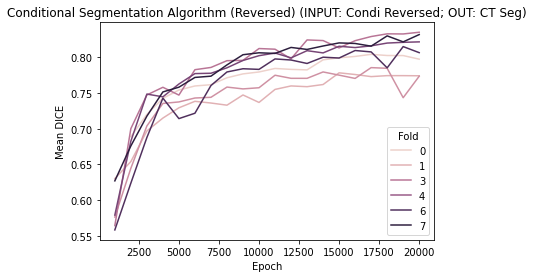

exp_type: segModeBoth
exp_name_title_mapping[exp_type]: CBCT & CT Segmentation (No 2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)


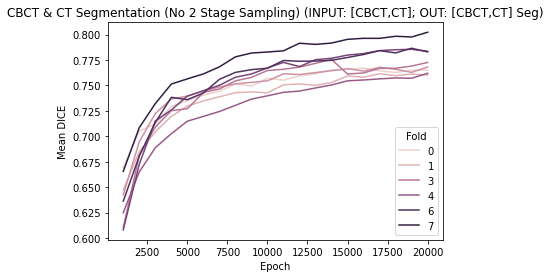

exp_type: segModeCBCT
exp_name_title_mapping[exp_type]: CBCT Segmentation (INPUT: CBCT; OUT: CBCT Seg)


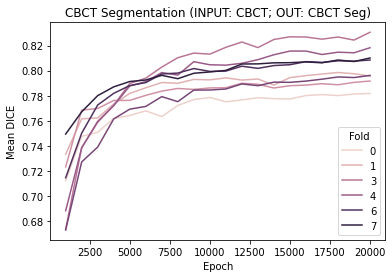

exp_type: segModeCT
exp_name_title_mapping[exp_type]: CT Segmentation (INPUT: CT; OUT: CBCT Seg)


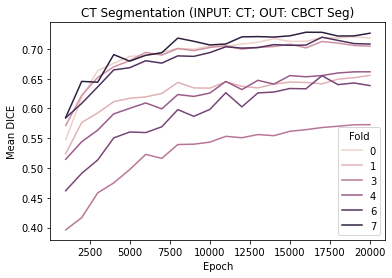

exp_type: segModeBoth_2sample
exp_name_title_mapping[exp_type]: CBCT & CT Segmentation (2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)


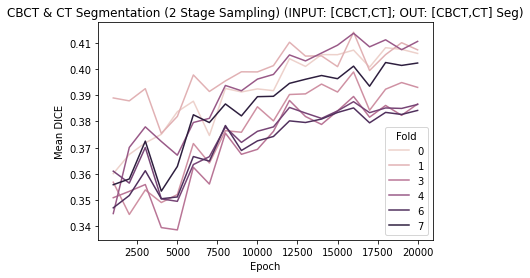

<Figure size 432x288 with 0 Axes>

In [32]:
train_val_test = "'val'"
value_type = "'dice_mean'"
plot_data_by_folds(exp_types, train_val_test, value_type, 20000, 1000, y_label = 'Mean DICE')
#todo fix ylabel

#### By Experiment

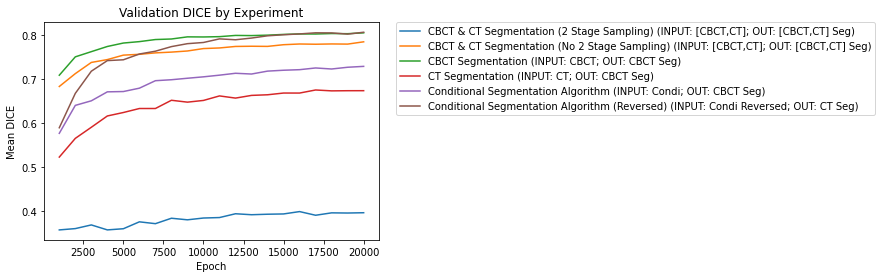

In [33]:
plot_data_aggregate(exp_types, "'val'", "'dice_mean'", 20000, 1000, title='Validation DICE by Experiment', y_label = 'Mean DICE')

#Notes from Yipeng
Would expect CT to be performing better as there is more information in CT images. Why is CT Lower?

### Validation DICE Standard Deviation

#### By Fold

exp_types: ['CondisegCBCT', 'CondisegReversed', 'segModeBoth', 'segModeCBCT', 'segModeCT', 'segModeBoth_2sample']
exp_type: CondisegCBCT
exp_name_title_mapping[exp_type]: Conditional Segmentation Algorithm (INPUT: Condi; OUT: CBCT Seg)


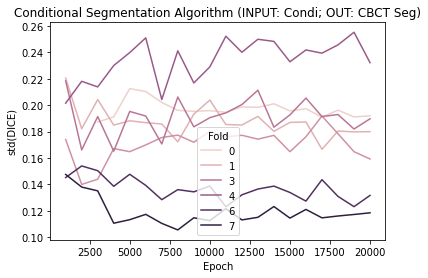

exp_type: CondisegReversed
exp_name_title_mapping[exp_type]: Conditional Segmentation Algorithm (Reversed) (INPUT: Condi Reversed; OUT: CT Seg)


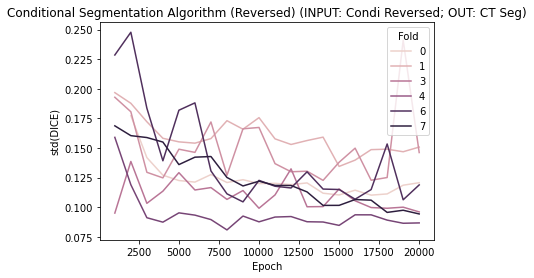

exp_type: segModeBoth
exp_name_title_mapping[exp_type]: CBCT & CT Segmentation (No 2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)


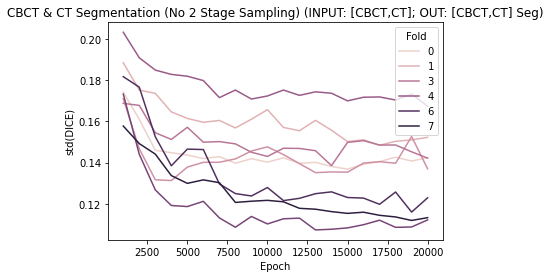

exp_type: segModeCBCT
exp_name_title_mapping[exp_type]: CBCT Segmentation (INPUT: CBCT; OUT: CBCT Seg)


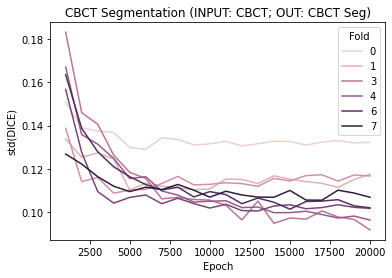

exp_type: segModeCT
exp_name_title_mapping[exp_type]: CT Segmentation (INPUT: CT; OUT: CBCT Seg)


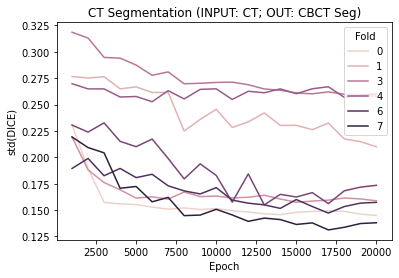

exp_type: segModeBoth_2sample
exp_name_title_mapping[exp_type]: CBCT & CT Segmentation (2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)


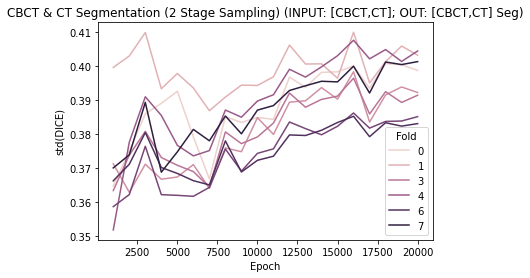

<Figure size 432x288 with 0 Axes>

In [34]:
train_val_test = "'val'"
value_type = "'dice_std'"
plot_data_by_folds(exp_types, train_val_test, value_type, 20000, 1000, y_label='std(DICE)')
#todo fix ylabel

#### By Experiment

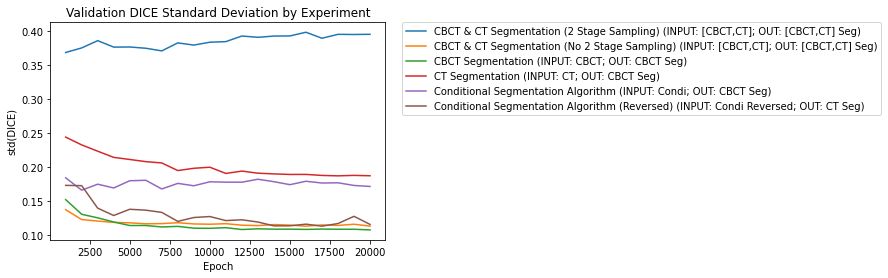

In [35]:
plot_data_aggregate(exp_types, "'val'", "'dice_std'", 20000, 1000, title='Validation DICE Standard Deviation by Experiment', y_label = 'std(DICE)')

### Test Mean Dice


### By Fold

In [36]:
import pickle as pkl

In [37]:
test_path = 'Experiments/exp_2_CS_and_CSRev/ConditionalSegReversed/CondisegReversed_cv0_nc16/results.pkl'

with open (test_path, 'rb') as f:
    results = pkl.load(f)

results


{'dice': [array(0.8794943, dtype=float32),
  array(0.6041194, dtype=float32),
  array(0.9488654, dtype=float32),
  array(0.86145145, dtype=float32),
  array(0.9355941, dtype=float32),
  array(0.44710892, dtype=float32),
  array(0.90577024, dtype=float32),
  array(0.78423125, dtype=float32),
  array(0.9367728, dtype=float32),
  array(0.7999395, dtype=float32),
  array(0.9217005, dtype=float32),
  array(0.74032646, dtype=float32)],
 'dice-wo-reg': [array(0.14902787, dtype=float32),
  array(0.07143804, dtype=float32),
  array(0.44811666, dtype=float32),
  array(0.34411386, dtype=float32),
  array(0.00348917, dtype=float32),
  array(0.04303997, dtype=float32),
  array(0.62144727, dtype=float32),
  array(0.456353, dtype=float32),
  array(0.24493645, dtype=float32),
  array(0.04058686, dtype=float32),
  array(0.90447843, dtype=float32),
  array(0.44524238, dtype=float32)]}

#### By Experiment

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


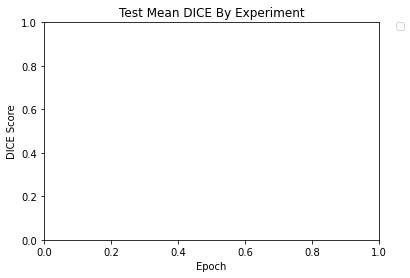

In [38]:
plot_data_aggregate(exp_types, "'test'", "'dice_mean'", 20000, 1000, title='Test Mean DICE By Experiment', y_label = 'DICE Score')

# Data Visualization

# Testing/Scratchpad
    

In [39]:
df[df['project'] == 'ConditionalSegReversed']

,project,exp_name,fold,train_val_test,epoch,value,value_type,experiment_group
891834,ConditionalSegReversed,CondisegReversed_cv0_nc16,0,'val',1880,0.694682,'dice_mean',Conditional Segmentation Algorithm (Reversed) ...
891835,ConditionalSegReversed,CondisegReversed_cv0_nc16,0,'val',1880,0.165893,'dice_std',Conditional Segmentation Algorithm (Reversed) ...
891836,ConditionalSegReversed,CondisegReversed_cv0_nc16,0,'train',1881,0.093280,'loss',Conditional Segmentation Algorithm (Reversed) ...
891837,ConditionalSegReversed,CondisegReversed_cv0_nc16,0,'val',1881,0.684008,'dice_mean',Conditional Segmentation Algorithm (Reversed) ...
891838,ConditionalSegReversed,CondisegReversed_cv0_nc16,0,'val',1881,0.157302,'dice_std',Conditional Segmentation Algorithm (Reversed) ...
...,...,...,...,...,...,...,...,...
1306191,ConditionalSegReversed,CondisegReversed_cv1_nc16,1,'val',19999,0.777189,'dice_mean',Conditional Segmentation Algorithm (Reversed) ...
1306192,ConditionalSegReversed,CondisegReversed_cv1_nc16,1,'val',19999,0.145258,'dice_std',Conditional Segmentation Algorithm (Reversed) ...
1306193,ConditionalSegReversed,CondisegReversed_cv1_nc16,1,'train',20000,0.043498,'loss',Conditional Segmentation Algorithm (Reversed) ...
1306194,ConditionalSegReversed,CondisegReversed_cv1_nc16,1,'val',20000,0.773943,'dice_mean',Conditional Segmentation Algorithm (Reversed) ...


In [40]:
df['experiment_group'] = df['exp_name'].map(exp_grouping)


In [41]:
df.experiment_group.unique()



array(['CBCT & CT Segmentation (2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)',
       'Conditional Segmentation Algorithm (INPUT: Condi; OUT: CBCT Seg)',
       'Conditional Segmentation Algorithm (Reversed) (INPUT: Condi Reversed; OUT: CT Seg)',
       nan, 'CBCT Segmentation (INPUT: CBCT; OUT: CBCT Seg)',
       'CBCT & CT Segmentation (No 2 Stage Sampling) (INPUT: [CBCT,CT]; OUT: [CBCT,CT] Seg)',
       'CT Segmentation (INPUT: CT; OUT: CBCT Seg)'], dtype=object)

In [42]:
#Creata a dictionary to map experiment name to a friendly name to be displayed on the chart for the corresponding experiment.
exp_name_title_mapping = {'CondisegCBCT': "Conditional Segmentation Algorithm",
                          'CondisegReversed': "Conditional Segmentation Algorithm (Reversed)",
                          'segModeBoth': "CBCT & CT Segmentation",
                          'segModeCBCT': "CBCT Segmentation",
                          'segModeCT': "CT Segmentation"}

In [43]:
exp_grouping = {}
#Create a dictionary to map experiment name to a list of experiments that are part of the same group.
#Loop through all unique experiment names (one for each fold per experiment)
for exp_name in df.exp_name.unique().tolist():
    #Then loop through the exp_types which are unique exp_name prefixes. Map to the Grouping

    #print(f"exp_name: {exp_name}")
    for exp_type in exp_name_title_mapping.keys():
        #print(f'exp_type: {exp_type}')
        if exp_name.startswith(exp_type):
            exp_grouping[exp_name] = exp_name_title_mapping[exp_type]
            break #break out of the loop since we found the exp_type
#print(exp_grouping)

df['experiment_group'] = df['exp_name'].map(exp_grouping)